# Contemporary Optimization

Let's begin, as usual, by recalling the standard problem of empirical risk minimization: 

In the simplest approach to empirical risk minimization, we began with a matrix of features $\mathbf{X} \in \mathbb{R}^{n\times p}$ and a vector of targets $\mathbf{y} \in \mathbb{R}^n$. We defined a linear score  $s =  \langle \mathbf{w}, \mathbf{x}\rangle$ which we interpreted as producing predictions of the value of $y$. We then defined a loss function $\ell: \mathbb{R}\times \mathbb{R} \rightarrow \mathbb{R}$ that told us the quality of the prediction $s$ by comparing it to a true target $y$. Our learning problem was to find $\mathbf{w}$ by minimizing the *empirical risk*: the mean (or sum) of the risk across all data points:  

$$
\DeclareMathOperator*{\argmin}{argmin}
\begin{aligned}
\hat{\mathbf{w}} &= \argmin_{\mathbf{w} \in \mathbb{R}^p} R(\mathbf{w}) \\ 
&= \argmin_{\mathbf{w} \in \mathbb{R}^p} \frac{1}{n}\sum_{i = 1}^n \ell(s_i, y_i) \\ 
                 &= \argmin_{\mathbf{w} \in \mathbb{R}^p} \frac{1}{n}\sum_{i = 1}^n \ell(\langle \mathbf{w}, \phi(\mathbf{x}_i) \rangle, y_i)\;. 
\end{aligned}
$$

Our most general approach to solving this problem was gradient descent. We would compute $\nabla R(\mathbf{w})$ and then make an update to $\mathbf{w}$ based on this information. The gradient of the empirical risk has the form 

$$
\begin{aligned}
\nabla R(\mathbf{w}) &= \frac{1}{n}\sum_{i = 1}^n \nabla \ell(\langle \mathbf{w}, \phi(\mathbf{x}_i) \rangle, y_i) \;.
\end{aligned}
$${#eq-gradient}

This worked for us as long as we were able to do the computation in @eq-gradient. However, in the setting of deep learning we face two fundamental problems: 

First, **we need to take the gradient with respect to more parameters than just $\mathbf{w}$**. For example, consider the model for the single-hidden-layer model from last time. This model required us to solve the problem 

$$
\hat{\mathbf{w}} = \argmin_{\mathbf{w} \in \mathbb{R}^q, \mathbf{U} \in \mathbb{R}^{p \times q}} \frac{1}{n}\sum_{i = 1}^n \ell(\langle \mathbf{w}, \alpha (\mathbf{x}_i \mathbf{U}) \rangle, y_i)\;, 
$${#eq-single-layer}

where $\mathbf{U}$ is another matrix and $\alpha$ is a nonlinear function which we apply entrywise. It is possible to explicitly write down the gradient of this loss with respect to both the parameters in $\mathbf{w}$ and the parameters in $\mathbf{U}$, but it's a headache! More importantly, we would have to redo the calculation every time we wanted to add more layers to our model. We'd then need to program them in, check for bugs, etc. Not good! 

Second, **we need to deal with very large data**. Note that computing the empirical risk in @eq-single-layer requires us to sum over all $n$ data points. This requires us to load *the entire data set into memory* -- not necessarily simultaneously, but at minimum in sequence. This can be very expensive, or even impossible, if the data set is very large. 

In this lecture, we'll approach these two issues with two fundamental facets of modern optimization: automatic differentiation and stochastic gradient descent. 

## Automatic Differentiation

Automatic differentiation is a class of algorithms for computing derivatives and gradients of functions without resorting to approximations and without needing to do any paper-and-pencil mathematics. Most approaches to automatic differentiation rely heavily on the *computational graph* framework which we briefly introduced in the previous lecture. 

A computational graph is a directed acyclic graph that describes the sequence of computations performed by a function. For example, consider the following function, which computes the loss in 1D linear regression on a single observation: 

$$
\mathcal{L}(w_0, w_1) =  (w_1x + w_0 - y)^2\;. 
$$

We might be accustomed to looking at functions like these and taking them in "all at once." We can, however, break down the steps into individual operations. Let's suppose that all we know how to do is add, subtract, and multiply pairs of numbers. We could write the complete sequence of calculations like this: 

$$
\begin{aligned}
    z_1 &= w_1 \times x \\
    z_2 &= z_1 + w_0 \\
    z_3 &= z_2 - y \\
    \mathcal{L} = z_4 &= z_3 \times z_3\;.
\end{aligned}
$$

A nicer way to present this sequence of calculations is through a computational graph. Here I've populated each node of the computational graph with the both the operation that is performed at that node as well as the value stored at that node. 

```{mermaid}

flowchart LR
    subgraph inputs
        w["w₁"]
        b["w₀"]
    end

    subgraph constants
        x
        y
    end

    w & x --> *["* (z₁)"]
    b & * --> +["+ (z₂)"]
    + & y --> -["- (z₃)"]
    - --> m["* (z₄)"]
    - --> m["* (z₄)"]
```

To compute derivatives, what we'll do is work backwards along this computational graph, computing the derivative of one node with respect to previous nodes. This algorithm is called *backpropagation*, [It is sometimes said that backprop is just the chain rule of (multivariable) calculus. [This is not entirely correct](https://theorydish.blog/2021/12/16/backpropagation-%e2%89%a0-chain-rule/). The chain rule is indeed the mathematical proof that backprop is correct, but backprop provides an extremely efficient, scalable way of *organizing* the computation of derivatives that is not implied by the chain rule.]{.aside} because it requires that we propagate derivatives backwards along the computational graph. Here's how it works in our case: 

$$
\begin{aligned}
    \frac{\partial \mathcal{L}}{\partial \mathcal{L}} &= 1 \\ 
    \frac{\partial \mathcal{L}}{\partial z_3} &= \frac{\partial \mathcal{L}}{\partial \mathcal{L}}\frac{\partial \mathcal{L}}{\partial z_3}      =  2z_3 \\ 
    \frac{\partial \mathcal{L}}{\partial z_2} &= \frac{\partial \mathcal{L}}{\partial z_3} \frac{\partial z_3}{\partial z_2}      = 2z_3\times 1 \\ 
    \frac{\partial \mathcal{L}}{\partial z_1} &= \frac{\partial \mathcal{L}}{\partial z_2} \frac{\partial z_2}{\partial z_1}      = 2z_3\times 1\times 1 \\ 
    \frac{\partial \mathcal{L}}{\partial w_1}   &= \frac{\partial \mathcal{L}}{\partial z_1} \frac{\partial z_1}{\partial w_1}        = 2z_3\times 1\times 1\times x \\ 
    \frac{\partial \mathcal{L}}{\partial w_0}   &= \frac{\partial \mathcal{L}}{\partial z_1} \frac{\partial z_1}{\partial w_0}        = 2z_3\times 1\times 1\times 1\;.
\end{aligned}
$$

These last two lines are the derivatives that we want. In order to finally compute the derivatives, we need to also replace the variables $z_1$, $z_2$, and $z_3$ with their values in terms of $w_0$, $w_1$, $x$, and $y$. This means that we need to replace $z_3$. From the computational graph, we have 
$$
\begin{aligned}
    z_3 = z_2 - y = z_1 + w_0 - y= w_1x + w_0 - y\;.
\end{aligned}
$$

Inserting this value of $z_3$ into the two formulae for our derivatives gives 

$$
\begin{aligned}
    \frac{\partial \mathcal{L}}{\partial w_1} &= 2(w_1x + w_0 - y)x \\ 
    \frac{\partial \mathcal{L}}{\partial w_0} &= 2(w_1x + w_0 - y)\;,
\end{aligned}
$$

which we can verify using standard calculus techniques. In summary, our approach to computing the derivative had two main steps: 

1. First, we went *forward* in the computational graph to compute the value of the loss funciton, saving the values of each intermediate node. 
2. Then, we went *backward* in the computational graph, using the chain rule and the values stored at each node to compute the derivatives. 


### Automatic Differentiation with Torch

It's now time for us to justify why we've been using PyTorch this whole time, when we could have just as easily been using NumPy. The reason is that *PyTorch implements automatic differentiation*. Let's try this with our example above. Let $x = 2$ and $y = 7$. Suppose that $\mathbf{w} = (1, 2)^T$. Analytically, the derivatives of the loss with respect to $\mathbf{w}$ are

$$
\begin{aligned}
    \frac{\partial \mathcal{L}}{\partial w_1} &= 2\times (w_1x + w_0 - y)\times x = 2\times (2\times 2 + 1 - 7)\times 2 = -8 \\ 
    \frac{\partial \mathcal{L}}{\partial w_0} &= 2\times (w_1x + w_0 - y) = 2\times (2\times 2 + 1 - 7) = -4\;.
\end{aligned}
$$

With Torch, we can compute these derivatives automatically, without relying on pencil-and-paper calculus. 

In [1]:
#---
import torch 

x = torch.tensor(2.0)
y = torch.tensor(7.0)

# requires_grad indicates that we should keep track of the gradient of this 
# variable when doing backpropagation. 
w = torch.tensor([1.0, 2.0], requires_grad=True)

# Compute the loss: this is the *forward* pass of the computational graph. 
loss = (w[1]*x + w[0] - y)**2

# Compute the gradient. This is the *backward* pass of the computational graph.
loss.backward()

# after calling loss.backward(), the gradient of the loss with respect to w is stored in w.grad
print(w.grad)
#---

tensor([-4., -8.])


Looks good! Torch implements automatic differentiation for a very large number of operations, including many which are commonly used in deep learning applications. 

## Stochastic Gradient Descent

Ok, so now we know that we can compute gradients of functions without resorting to pencil-and-paper calculus. But we are still facing down our second problem: how can we compute the gradient required by @eq-gradient in cases when it's impractical to load the entire data set into memory? Here's a simple answer: don't! Instead of computing complete gradients, we'll compute *stochastic gradients*. A stochastic gradient is an approximation of the complete gradient computed using a subset of the data points. 

Let $I = \{i_1, i_2, \ldots, i_k\}$ be a random subset of the indices $\{1, 2, \ldots, n\}$. Then the stochastic gradient is

$$
\begin{aligned}
    \nabla_I R(\mathbf{w}) &= \frac{1}{k}\sum_{i \in I} \nabla \ell(\langle \mathbf{w}, \phi(\mathbf{x}_i) \rangle, y_i) \;.
\end{aligned}
$${#eq-stochastic-gradient}

In (regular) stochastic gradient descent, the set $I$ contains a single index, while in mini-batch stochastic gradient descent, the set $I$ contains multiple indices (but typically many, many fewer than the overall size of the data set). 

Importantly, we can view the stochastic gradient as the gradient of the loss averaged over the indices $I$: 

$$
\begin{aligned}
\mathcal{R}_I = \frac{1}{k}\sum_{i \in I} \ell(\langle \mathbf{w}, \phi(\mathbf{x}_i) \rangle, y_i)\;.
\end{aligned}
$$

This means that if we compute this loss and then perform a backward pass to compute its gradient, we'll have exactly the information we need to perform a stochastic gradient step. 

### Vanilla Stochastic Gradient Descent

In the simplest form of stochastic gradient descent, we choose a batch size and a learning rate and iterate an update very similar to standard gradient descent. It is typically desired that the learning rate *shrink* over time to ensure convergence.[The function describing how the learning rate shrinks over time is called the *learning schedule*.]{.aside} Here's a complete example of minibatch least-squares linear regression in one dimension. First we'll generate some data:

In [7]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
def regression_data(n = 100, w = torch.Tensor([-0.7, 0.5]), x_max = 1):

    x = torch.rand(n)*x_max
    y = x*w[1] + w[0] + 0.05*torch.randn(n)
    return x, y

x, y = regression_data()

Then, we'll implement a loss function and a training loop

In [3]:
# mean squared error
def mse(x, y, w):
    return ((w[1]*x + w[0] - y)**2).mean()

def learning_schedule(t): 
    return 10/(t + 10)

batch_size = 10

# initialize training loop
w = torch.tensor([0.0, 0.0], requires_grad=True)
losses = []
minibatch_losses = []

#---
for t in range(1, 1000):
    # choose a random batch of indices
    i = torch.randint(0, x.shape[0], (batch_size,))

    # compute the loss
    minibatch_loss = mse(x[i], y[i], w)

    # record the minibatchloss
    minibatch_losses.append(minibatch_loss.item())

    # full loss : only for viz, not part of algorithm
    losses.append(mse(x, y, w).item())

    # compute the gradient
    minibatch_loss.backward()

    # update the weights
    # the with statement is boilerplate that tells torch not to keep track of the gradient for the operation of updating w
    with torch.no_grad():
        w -= learning_schedule(t)*w.grad

    # zero the gradient
    w.grad.zero_()
#---

Unlike in the case of standard gradient descent, the loss function is not guaranteed to decrease monotonically: 

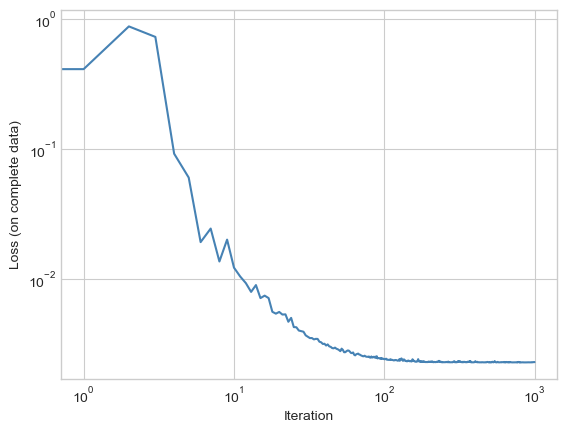

In [4]:
plt.plot(losses, color = "steelblue")
plt.loglog()
labs = plt.gca().set(xlabel = "Iteration", ylabel = "Loss (on complete data)")

Increasing the batch size and tuning the learning schedule can help facilitate rapid convergence. 

### Fancy Stochastic Gradient Descent

There are many variations of stochastic gradient descent that use more information than just the gradient of the current stochastic loss. For example, you may have implemented gradient descent with *momentum* on a previous assignment. Torch conveniently implements a range of more sophisticated optimization methods, most of which require only that one can quickly compute the gradient of loss with respect to parameters. For example, here's a concise of the same training loop as above using a custom optimizer which implements the [adagrad algorithm](https://jmlr.org/papers/v12/duchi11a.html). 

In [5]:
w = torch.tensor([0.0, 0.0], requires_grad=True)
losses = []

#---
opt = torch.optim.Adagrad([w], lr = 0.5)
#---

for t in range(1, 1000):

    # these steps are the same as before
    i = torch.randint(0, x.shape[0], (batch_size,))
    minibatch_loss = mse(x[i], y[i], w)
    losses.append(mse(x, y, w).item())
    minibatch_loss.backward()

    #---
    # instead of manually updating w, instead we just call the step method of the optimizer
    opt.step()

    # we can also use the optimizer to zero out gradients
    opt.zero_grad()
    #---

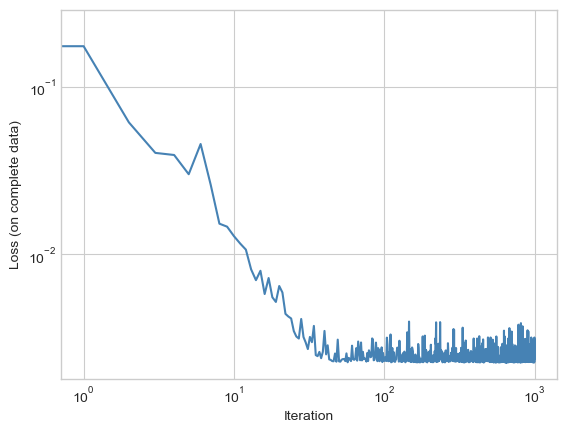

In [6]:
plt.plot(losses, color = "steelblue")
plt.loglog()
labs = plt.gca().set(xlabel = "Iteration", ylabel = "Loss (on complete data)")

Perhaps the most common form of fancy stochastic gradient descent is the *Adam* algorithm by @kingma2015adam, which is implemented as `torch.optim.Adam`.

## Looking Ahead

We've now taken two jumps toward large, complicated machine learning models. First, we learned how to compute gradients of arbitrary differentiable functions using automatic differentiation. This allows us to move beyond functions and models for which we can compute gradients automatically. Second, we learned how to compute approximations of the gradient of the empirical risk and use these approximations for optimization. The resulting class of  *stochastic gradient descent* algorithms is used almost exclusively in modern large-scale machine learning. 

### What Happened to Convexity? 

Unfortunately, very little of our theory from convex optimization is going to carry over to the setting of deep learning. In particular, adding the feature maps $\phi$ as objects of optimization almost always makes the empirical risk minimization problem nonconvex. We should typically expect that our optimization problems will have many local minima and that there is a danger of our model being trapped in those minima. 